In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
INPUT_FILE = "expensedata.csv"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
# Step 2: Load raw data
df_raw = pd.read_csv(INPUT_FILE)
df_raw.head()


,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.0,Expense,NaN,50.0,INR,50.0
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.0,Expense,NaN,300.0,INR,300.0
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.0,Expense,NaN,78.0,INR,78.0
3,3/1/2022 18:56,CUB - online payment,Transportation,NaN,Metro,30.0,Expense,NaN,30.0,INR,30.0
4,3/1/2022 18:22,CUB - online payment,Food,NaN,Snacks,67.0,Expense,NaN,67.0,INR,67.0


In [3]:
# Step 3: Clean the dataset

def clean_data(df):
    # Drop empty columns
    cols_all_null = df.columns[df.isnull().all()].tolist()
    df = df.drop(columns=cols_all_null)

    # Drop duplicate columns
    if "INR" in df.columns and "Amount" in df.columns:
        if np.allclose(df["INR"].fillna(0), df["Amount"].fillna(0)):
            df = df.drop(columns=["INR"])
    if "Account.1" in df.columns:
        df = df.drop(columns=["Account.1"])

    # Rename
    df = df.rename(columns={"Income/Expense": "Type"})
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)

    # Standardize text
    df["Category"] = df["Category"].astype(str).str.strip().str.title()
    df["Account"] = df["Account"].astype(str).str.strip()
    df["Note"] = df["Note"].astype(str).str.strip()

    # Amount
    df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")

    # Normalize Type
    df["Type"] = df["Type"].astype(str).str.strip().str.title()
    df["Type"] = df["Type"].replace({"Expence":"Expense","Debit":"Expense","Credit":"Income"})

    # SignedAmount
    df["SignedAmount"] = df.apply(lambda r: -abs(r["Amount"]) if r["Type"]=="Expense" else abs(r["Amount"]), axis=1)

    # Date parts
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["MonthName"] = df["Date"].dt.strftime("%Y-%m")

    return df[["Date","Year","Month","MonthName","Account","Category","Note","Type","Amount","SignedAmount"]]

df = clean_data(df_raw)
df.head()


,Date,Year,Month,MonthName,Account,Category,Note,Type,Amount,SignedAmount
0,2022-02-03 10:11:00,2022.0,2.0,2022-02,CUB - online payment,Food,Brownie,Expense,50.0,-50.0
1,2022-02-03 10:11:00,2022.0,2.0,2022-02,CUB - online payment,Other,To lended people,Expense,300.0,-300.0
2,2022-01-03 19:50:00,2022.0,1.0,2022-01,CUB - online payment,Food,Dinner,Expense,78.0,-78.0
3,2022-01-03 18:56:00,2022.0,1.0,2022-01,CUB - online payment,Transportation,Metro,Expense,30.0,-30.0
4,2022-01-03 18:22:00,2022.0,1.0,2022-01,CUB - online payment,Food,Snacks,Expense,67.0,-67.0


In [4]:
# Step 4: Basic Statistics
total_expense = df.loc[df["Type"]=="Expense","Amount"].sum()
total_income = df.loc[df["Type"]=="Income","Amount"].sum()
net = total_income - total_expense
avg_expense = df.loc[df["Type"]=="Expense","Amount"].mean()

print("=== Expense Summary ===")
print(f"Total Expense: {total_expense:.2f}")
print(f"Total Income: {total_income:.2f}")
print(f"Net: {net:.2f}")
print(f"Average Expense: {avg_expense:.2f}")
print(f"Transactions: {len(df)}")


=== Expense Summary ===
Total Expense: 57918.28
Total Income: 54754.00
Net: -3164.28
Average Expense: 250.73
Transactions: 277


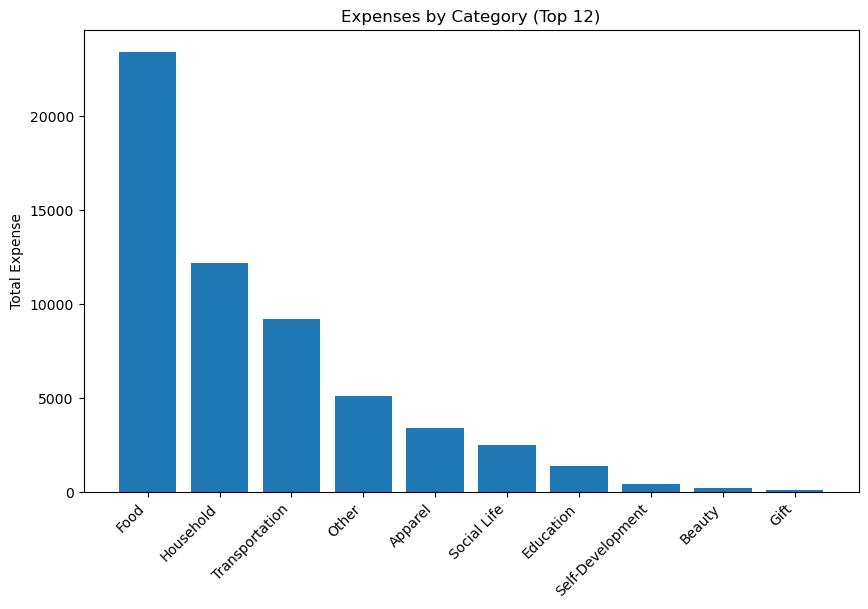

In [5]:
# Step 5: Visualization

# Expenses by Category
cat_sum = df[df["Type"]=="Expense"].groupby("Category")["Amount"].sum().sort_values(ascending=False).head(12)
plt.figure(figsize=(10,6))
plt.bar(cat_sum.index, cat_sum.values)
plt.xticks(rotation=45, ha="right")
plt.title("Expenses by Category (Top 12)")
plt.ylabel("Total Expense")
plt.show()


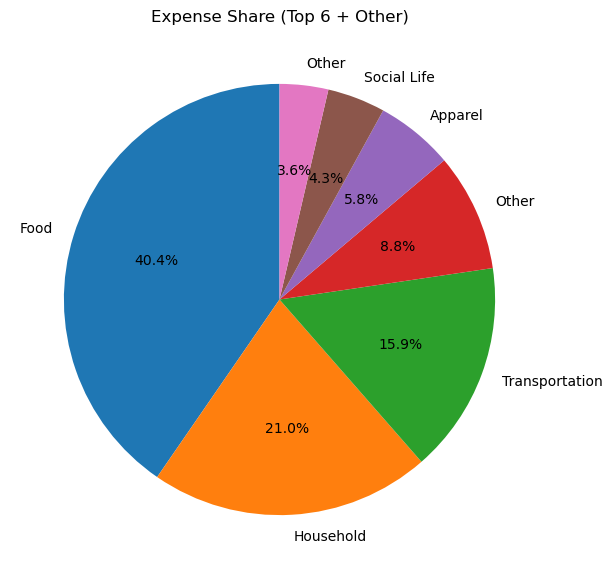

In [7]:
# Expense Share Pie Chart
cat_sum = df[df["Type"]=="Expense"].groupby("Category")["Amount"].sum().sort_values(ascending=False)
top6 = cat_sum.head(6)
other = cat_sum[6:].sum()
values = list(top6.values) + ([other] if other>0 else [])
labels = list(top6.index) + (["Other"] if other>0 else [])

plt.figure(figsize=(7,7))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Expense Share (Top 6 + Other)")
plt.show()


In [8]:
# Step 6: Save cleaned dataset
df.to_csv(os.path.join(OUTPUT_DIR, "cleaned_expenses.csv"), index=False)
print("Cleaned data saved to", os.path.join(OUTPUT_DIR, "cleaned_expenses.csv"))


Cleaned data saved to outputs\cleaned_expenses.csv
